# PINNs: Static (PyTorch)


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciml-book/sciml_notebook/blob/main/pinns/01-static.ipynb)

In [9]:
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

class PINNStaticModel:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """Initialize the model and loss history."""
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
        self.loss_history = {'total': [], 'boundary': [], 'differential': []}

    def get_derivative(self, y, x):
        """Compute the derivative of y with respect to x."""
        dydx = grad(y, x, torch.ones(x.size()[0], 1),
                    create_graph=True,
                    retain_graph=True)[0]
        return dydx

    def compute_pinn_residual(self, x, EA, p):
        """Compute the residual of the governing differential equation."""
        u = self.model(x)
        u_x = self.get_derivative(u, x)
        EAu_xx = self.get_derivative(EA(x) * u_x, x)
        f = EAu_xx + p(x)
        return f

    def compute_loss(self, x, EA, p):
        """
        Compute boundary and differential equation losses.
        - Boundary condition loss at x = 0 and x = 1.
        - Differential equation loss as the mean squared error of the residual.
        """
        # Boundary condition loss
        u0_pred = self.model(torch.tensor([[0.0]]))
        u1_pred = self.model(torch.tensor([[1.0]]))
        MSE_b = (u0_pred - 0)**2 + (u1_pred - 0)**2

        # Differential equation loss
        f_pred = self.compute_pinn_residual(x, EA, p)
        MSE_pde = torch.mean(f_pred**2)

        return MSE_b, MSE_pde

    def train(self, x, EA, p, epochs=50, lr=0.1):
        """
        Train the model with LBFGS optimizer.
        Track the progress using tqdm.
        """
        optimizer = torch.optim.LBFGS(self.model.parameters(),
                                      lr=lr,
                                      max_iter=20,
                                      max_eval=25,
                                      tolerance_grad=1e-7,
                                      tolerance_change=1e-9,
                                      history_size=50)
        pbar = tqdm(total=epochs, desc="Training", position=0, leave=True)

        def closure():
            optimizer.zero_grad()
            MSE_b, MSE_pde = self.compute_loss(x, EA, p)
            loss = MSE_b + MSE_pde
            loss.backward()
            
            # Update loss history
            self.loss_history['total'].append(loss.item())
            self.loss_history['boundary'].append(MSE_b.item())
            self.loss_history['differential'].append(MSE_pde.item())
            
            # Update progress bar description with current losses
            pbar.set_description(f"Loss: {loss.item():.2e}")
            return loss

        for _ in range(epochs):
            optimizer.step(closure)
            pbar.update(1)
        pbar.close()

    def plot_results(self, x):
        """Plot the model predictions and training loss history."""
        plt.figure(figsize=(12, 5))

        # Plot 1: Displacements
        plt.subplot(1, 2, 1)
        x_np = x.detach().numpy()
        u_analytic = np.sin(2 * np.pi * x_np)
        u_pred = self.model(x).detach().numpy()

        plt.plot(x_np, u_analytic, 'r-', label='$u_{analytic}$')
        plt.plot(x_np, u_pred, 'k--', label='$u_{pred}$')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('Displacements')
        plt.legend()
        plt.grid(False)

        # Plot 2: Cost function history
        plt.subplot(1, 2, 2)
        epochs = range(len(self.loss_history['total']))
        plt.semilogy(epochs, self.loss_history['total'], 'k-', label='Total cost')
        plt.semilogy(epochs, self.loss_history['differential'], 'g-.', label='Differential equation loss')
        plt.semilogy(epochs, self.loss_history['boundary'], 'r-.', label='Boundary condition loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss function $\mathcal{L}$')
        plt.title('Loss function history')
        plt.legend()
        plt.grid(False)

        plt.tight_layout()
        plt.show()

Training PINN for static bar problem...


Loss: 5.56e-05: 100%|██████████| 50/50 [00:01<00:00, 45.57it/s]


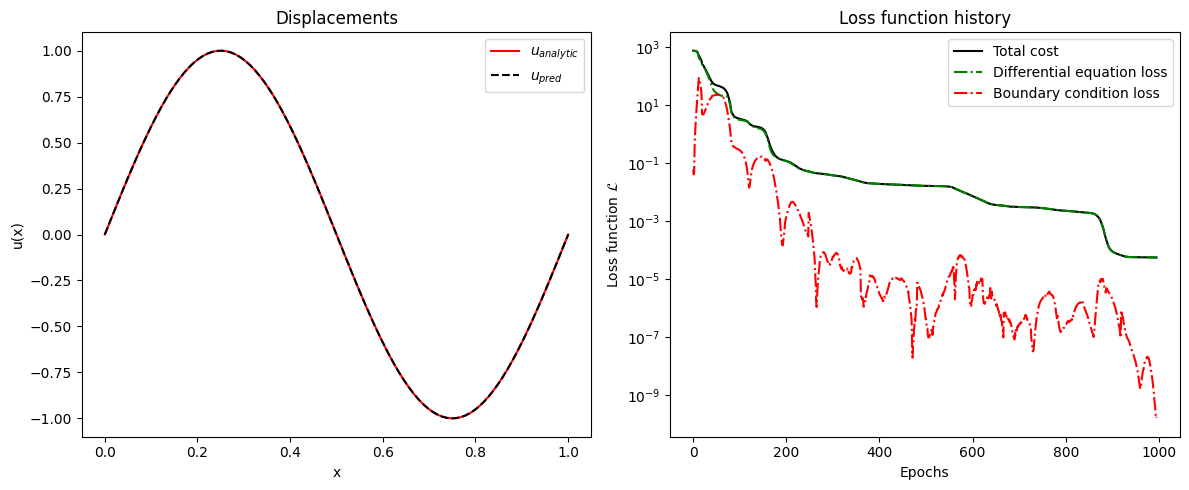


Final loss: 5.56e-05


In [11]:
# Model setup
model = PINNStaticModel(input_dim=1, hidden_dim=10, output_dim=1)
x = torch.linspace(0, 1, 100, requires_grad=True).view(-1, 1)
EA = lambda x: 1 + 0 * x
p = lambda x: 4 * math.pi**2 * torch.sin(2 * math.pi * x)

print("Training PINN for static bar problem...")

# Training
model.train(x, EA, p, epochs=50, lr=0.1)

# Plot results
model.plot_results(x)
print("\nFinal loss: {:.2e}".format(model.loss_history['total'][-1]))

